# Excited States via LR-VQE (Tangent-Space TDA)

This notebook validates that:
- A reference ground-state VQE run produces converged parameters θ*
- LR-VQE builds the tangent-space generalized eigenproblem and returns excitation energies

It prints:
- Lowest exact eigenvalues of a reference Hamiltonian
- Reference VQE energy E0
- LR excitation energies ω_i and excited energies E0 + ω_i
- |ΔE| vs nearest exact eigenvalue (sanity)

In [7]:
import numpy as np
import pennylane as qml
from pennylane import qchem

from vqe.lr_vqe import run_lr_vqe


## Configuration

In [8]:
molecule = "H2"
k = 4

ansatz_name = "UCCSD"
optimizer_name = "Adam"
steps = 80
stepsize = 0.2
seed = 0
mapping = "jordan_wigner"

fd_eps = 1e-3
eps = 1e-10

force = False

## Exact spectrum benchmark (reference Hamiltonian)

In [9]:
sym = ["H", "H"]
coords = np.array(
    [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.7414],
    ],
    dtype=float,
)
basis = "sto-3g"

H_ref, n_wires = qchem.molecular_hamiltonian(sym, coords, basis=basis, unit="Angstrom")

Hmat = np.array(qml.matrix(H_ref), dtype=complex)
exact_evals = np.sort(np.linalg.eigvalsh(Hmat).real)

print(f"Molecule: {molecule}")
print(f"Qubits:   {n_wires}")
print(f"Basis:    {basis}")
print(f"Lowest {max(10, k)} exact eigenvalues (Ha):")
for i, e in enumerate(exact_evals[: max(10, k)]):
    print(f"#{i:>2}: {float(e): .10f}")

Molecule: H2
Qubits:   4
Basis:    sto-3g
Lowest 10 exact eigenvalues (Ha):
# 0: -1.1372701749
# 1: -0.5387095807
# 2: -0.5387095807
# 3: -0.5324790143
# 4: -0.5324790143
# 5: -0.5324790143
# 6: -0.4469857253
# 7: -0.4469857253
# 8: -0.1699013991
# 9:  0.2378052722


## Helpers

In [10]:
def _nearest_exact_energy(E: float, exact: np.ndarray) -> tuple[float, float, int]:
    diffs = np.abs(exact - float(E))
    j = int(np.argmin(diffs))
    return float(exact[j]), float(diffs[j]), j


def summarize_lr(result: dict, exact: np.ndarray, *, label: str) -> None:
    E0 = float(result["reference_energy"])
    omegas = np.array(result["excitations"], dtype=float)
    energies = np.array(result["eigenvalues"], dtype=float)

    print("\n" + "=" * 80)
    print(label)
    print("=" * 80)
    print(f"E0 (reference): {E0:+.10f} Ha")
    print(f"num_qubits:     {int(result['num_qubits'])}")
    print()

    for i, (w, E) in enumerate(zip(omegas, energies)):
        target, err, j = _nearest_exact_energy(float(E), exact)
        print(
            f"root {i:>2}:  ω = {float(w):+.10f} Ha   "
            f"E = E0+ω = {float(E):+.10f} Ha   "
            f"nearest exact[{j}] = {target:+.10f} Ha   |ΔE| = {err:.3e} Ha"
        )

## LR-VQE (tangent-space TDA)

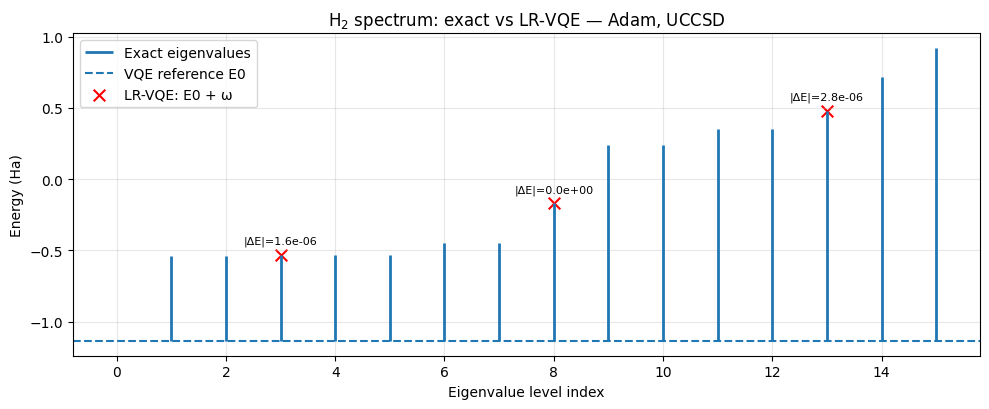

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/lr_vqe_spectrum_UCCSD_Adam_s0.png


In [11]:
lr_res = run_lr_vqe(
    molecule=molecule,
    k=k,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    mapping=mapping,
    fd_eps=fd_eps,
    eps=eps,
    force=force,
    plot=True,
    save=True,
)


## Summary table

In [12]:
summarize_lr(lr_res, exact_evals, label="Noiseless LR-VQE (tangent-space TDA)")


Noiseless LR-VQE (tangent-space TDA)
E0 (reference): -1.1372694521 Ha
num_qubits:     4

root  0:  ω = +0.6047888080 Ha   E = E0+ω = -0.5324806442 Ha   nearest exact[3] = -0.5324790143 Ha   |ΔE| = 1.630e-06 Ha
root  1:  ω = +0.9673680531 Ha   E = E0+ω = -0.1699013991 Ha   nearest exact[8] = -0.1699013991 Ha   |ΔE| = 0.000e+00 Ha
root  2:  ω = +1.6171027534 Ha   E = E0+ω = +0.4798333013 Ha   nearest exact[13] = +0.4798361027 Ha   |ΔE| = 2.801e-06 Ha


## Diagnostics: overlap spectrum

In [13]:
diag = lr_res.get("diagnostics", {})
S_eigs = diag.get("S_eigs", [])

print("Overlap eigenvalues (S):")
for i, x in enumerate(S_eigs):
    print(f"  s[{i:>2}] = {float(x): .6e}")

print()
print(f"kept_rank: {diag.get('kept_rank', None)}")
print(f"eps:       {diag.get('eps', None)}")
print(f"fd_eps:    {diag.get('fd_eps', None)}")

Overlap eigenvalues (S):
  s[ 0] =  2.495892e-01
  s[ 1] =  2.500000e-01
  s[ 2] =  2.504100e-01

kept_rank: 3
eps:       1e-10
fd_eps:    0.001
